## 债券违约预测

### 1. 问题说明

利用机器学习方法，根据发债企业的违约信息以及企业的财务信息数据建立模型，提取有效的特征并预测发债企业是否存在违约风险。

### 2. 加载数据和 python 包

In [69]:
# 加载需要的库
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV,cross_val_predict
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb

# 忽略警告信息
import warnings
warnings.filterwarnings('ignore')

In [70]:
# 加载数据
dataset = pd.read_csv('data_all.csv', encoding='gbk', sep=',', index_col=0)
dataset.head(5)
dataset.rename(columns={'credit':'isDefault'},inplace=True)

数据具有178列，其中isDefault表示该企业是否违约

### 3.描述性统计

#### 3.1 违约企业的省份分布
绘制违约企业的省份分布饼状图，可以看到不同省份企业违约的风险具有显著差距

Text(0.5, 1.0, '各省份违约企业比例图')

<Figure size 1440x720 with 0 Axes>

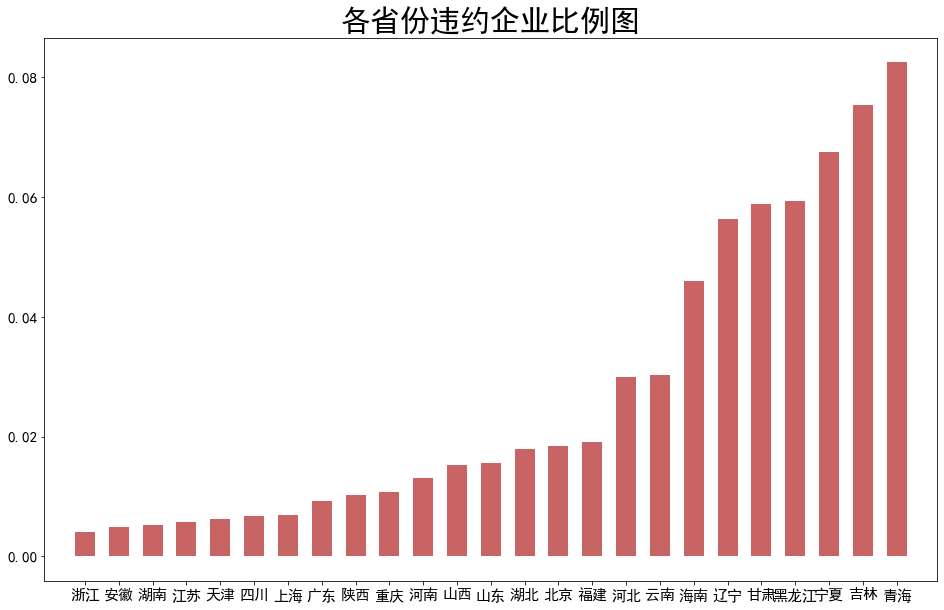

In [71]:
rank_rate = dataset[dataset['isDefault'] == 1]['prov'].value_counts()/dataset['prov'].value_counts()
rank_rate.dropna(inplace=True)
rank_rate.sort_values(ascending = True,inplace=True)
plt.rcParams['font.sans-serif'] = ['SimHei']  #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决中文显示问题
plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 10))
plt.figure(figsize=(16,10))
plt.vlines(x=rank_rate.index,ymin=0,ymax=rank_rate.values,color='firebrick',alpha=0.7,linewidth=20)
plt.title('各省份违约企业比例图', fontsize=30)  #加标题

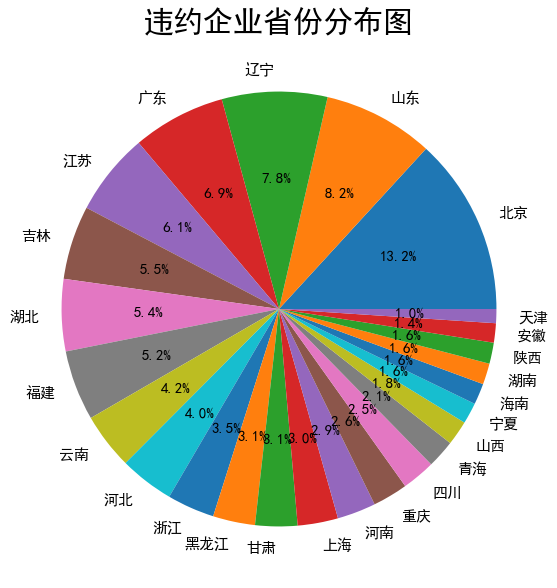

In [72]:
rate = dataset[dataset['isDefault'] == 1]['prov'].value_counts() / dataset[dataset['isDefault'] == 1]['prov'].count()
plt.rcParams['font.sans-serif'] = ['SimHei']  #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决中文显示问题
plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 10))
plt.pie(rate, labels=rate.index, autopct='%3.1f%%',
        labeldistance=1.1)  #以时间为标签，总计成交笔数为数据绘制饼图，并显示3位整数一位小数
plt.title('违约企业省份分布图', fontsize=30)  #加标题
plt.show()

#### 3.2 违约企业的行业分布
绘制违约企业的行业分布饼状图，可以看到不同行业企业违约的风险具有显著差距

Text(0.5, 1.0, '各行业违约企业比例图')

<Figure size 1440x720 with 0 Axes>

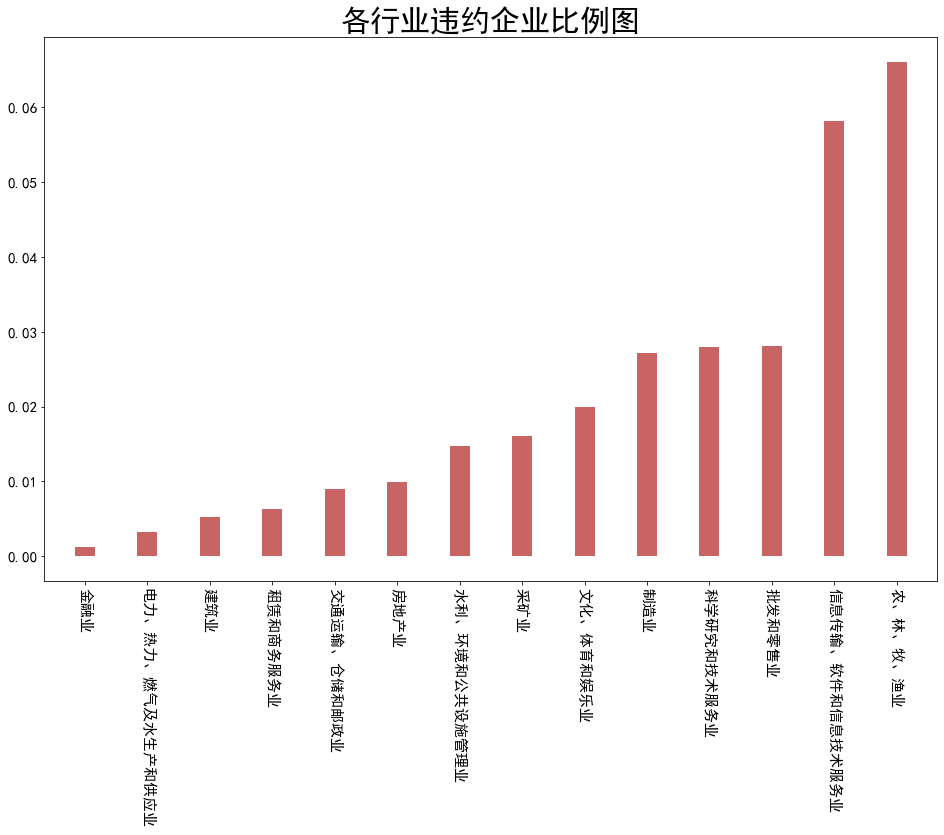

In [73]:
import matplotlib.ticker as ticker
rank_rate = dataset[dataset['isDefault'] == 1]['industryphy'].value_counts()/dataset['industryphy'].value_counts()
rank_rate.dropna(inplace=True)
rank_rate.sort_values(ascending = True,inplace=True)
plt.rcParams['font.sans-serif'] = ['SimHei']  #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决中文显示问题
plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 10))
plt.figure(figsize=(16,10))

plt.vlines(x=rank_rate.index,ymin=0,ymax=rank_rate.values,color='firebrick',alpha=0.7,linewidth=20)
plt.xticks(rotation=270)
plt.title('各行业违约企业比例图', fontsize=30)  #加标题

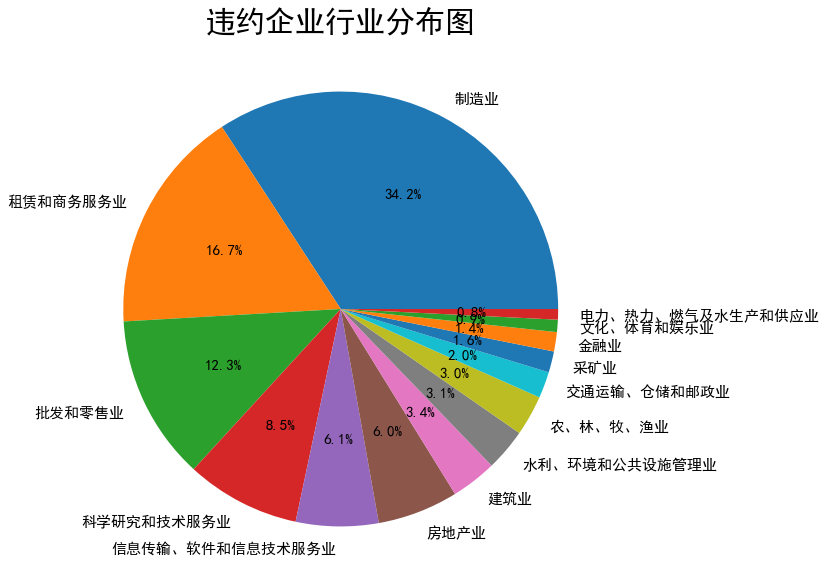

In [74]:
industry_rate = dataset[
    dataset['isDefault'] == 1]['industryphy'].value_counts() / dataset[
        dataset['isDefault'] == 1]['industryphy'].count()
plt.rcParams['font.sans-serif'] = ['SimHei']  #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决中文显示问题
plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 10))
plt.pie(industry_rate,
        labels=industry_rate.index,
        autopct='%3.1f%%',
        labeldistance=1.1)  #以时间为标签，总计成交笔数为数据绘制饼图，并显示3位整数一位小数
plt.title('违约企业行业分布图', fontsize=30)  #加标题
plt.show()

#### 3.3 违约企业的企业类型分布
绘制违约企业的企业类型分布饼状图，可以看到不同类型的企业违约的风险具有显著差距

Text(0.5, 1.0, '各企业类型违约企业比例图')

<Figure size 1440x720 with 0 Axes>

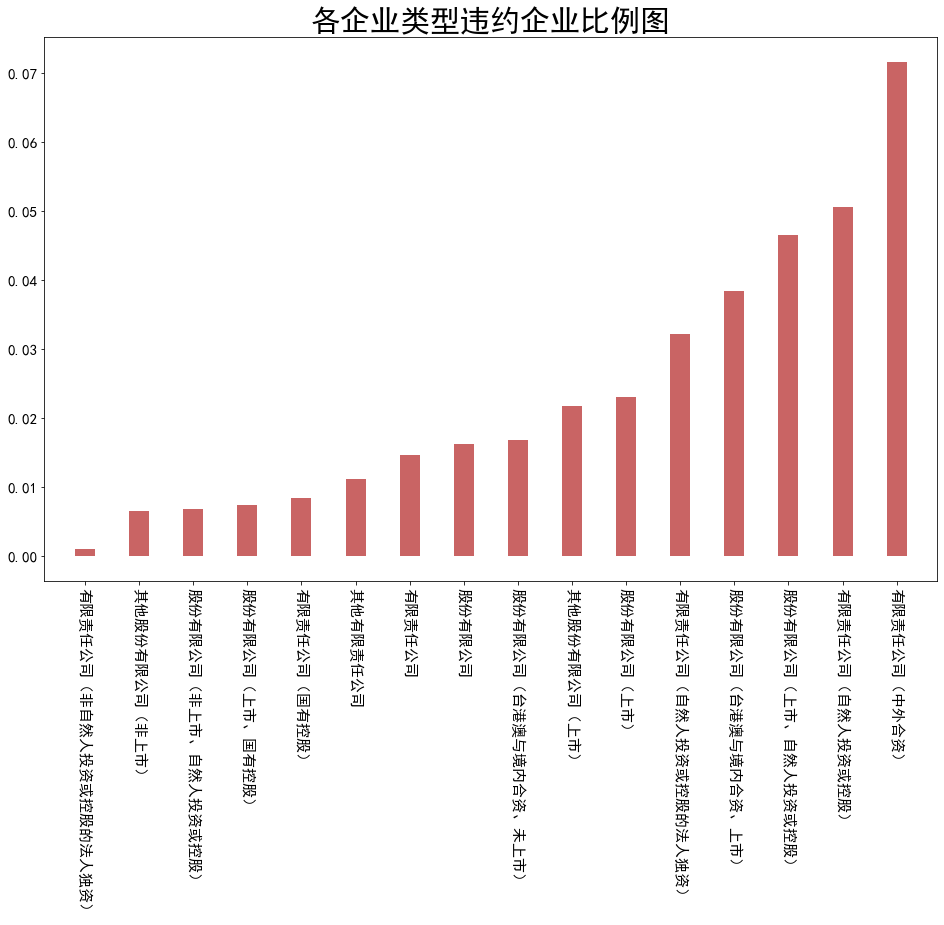

In [76]:
rank_rate = dataset[dataset['isDefault'] == 1]['enttype'].value_counts()/dataset['enttype'].value_counts()
rank_rate.dropna(inplace=True)
rank_rate.sort_values(ascending = True,inplace=True)
rank_rate.drop(index = ['集团','有限责任公司（中外合作）'],inplace = True)
plt.rcParams['font.sans-serif'] = ['SimHei']  #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决中文显示问题
plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 10))
plt.figure(figsize=(16,10))
plt.vlines(x=rank_rate.index,ymin=0,ymax=rank_rate.values,color='firebrick',alpha=0.7,linewidth=20)
plt.xticks(rotation=270)
plt.title('各企业类型违约企业比例图', fontsize=30)  #加标题

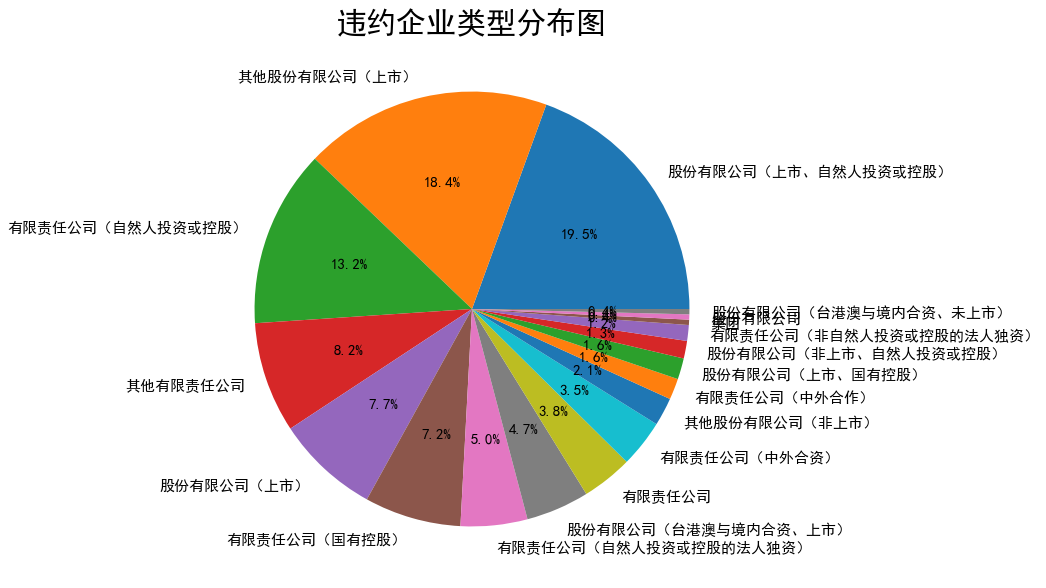

In [77]:
enttype_rate = dataset[dataset['isDefault'] == 1]['enttype'].value_counts(
) / dataset[dataset['isDefault'] == 1]['enttype'].count()
plt.rcParams['font.sans-serif'] = ['SimHei']  #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决中文显示问题
plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 10))
plt.pie(enttype_rate,
        labels=enttype_rate.index,
        autopct='%3.1f%%',
        labeldistance=1.1)  #以时间为标签，总计成交笔数为数据绘制饼图，并显示3位整数一位小数
plt.title('违约企业类型分布图', fontsize=30)  #加标题
plt.show()

### 4. 数据准备

#### 4.1 删除无用的字段
将企业ID、是否发债（均为Y）、成立日期，存续日期等无效字段删除

In [78]:
drop_list = [ 'ent_id', 'report_period', 'industryco', 'opfrom', 'opto', 'esdate', 'apprdate', 'entstatus', 'city', 'county', 'is_bondissuer' ]
dataset.drop(labels=drop_list, axis=1, inplace=True)

#### 4.2 类型特征处理
对行业、省份、企业类型三个类型特征进行编码处理

In [79]:
# 行业字段
len(dataset['industryphy'].value_counts())

20

In [80]:
# 省份字段
len(dataset['prov'].value_counts())

31

In [81]:
# 企业类型字段
import copy
enttype = copy.deepcopy(dataset['enttype'])
enttype = list(enttype)
for i in range(len(enttype)):
    if '（' in enttype[i]:
        enttype[i] = enttype[i].split('（')[-1][:-1]
    else:
        enttype[i] = "无"
dataset['enttype'] = enttype
len(dataset['enttype'].value_counts())

35

In [82]:
# 对类型字段进行编码
categorical_cols = dataset.columns[dataset.dtypes == object].tolist()
categorical_cols
encoder = LabelEncoder()
dataset[categorical_cols] = dataset[categorical_cols].apply(
    lambda col: encoder.fit_transform(col))
dataset[categorical_cols].head(5)

,industryphy,enttype,prov
0,17,18,14
1,15,26,29
2,15,26,11
3,17,34,18
4,17,34,18


#### 4.3 空值处理

In [83]:
# 检查数据中是否存在空值
dataset.isnull().values.any()

True

In [84]:
# 空值比例统计
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
missing_fractions.head(10)

s_fa_roe_avg                    0.839490
rd_expense                      0.791148
s_qfa_deductedprofittoprofit    0.778038
s_fa_deductedprofittoprofit     0.750638
s_qfa_roe_deducted              0.742408
s_fa_yoyeps_diluted             0.740797
s_qfa_deductedprofit            0.740287
s_fa_eps_diluted                0.735391
s_fa_yoynetprofit_deducted      0.728469
s_fa_yoyeps_basic               0.725136
dtype: float64

In [85]:
# 删除空值多于30%的特征
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)
dataset.drop(labels=drop_list, axis=1, inplace=True)


['rd_expense', 's_fa_capitalizedtoda', 's_fa_deductedprofit', 's_fa_deductedprofittoprofit', 's_fa_ebitda', 's_fa_ebitdatodebt', 's_fa_eps_basic', 's_fa_eps_diluted', 's_fa_extraordinary', 's_fa_longdebttoworkingcapital', 's_fa_ocftooperateincome', 's_fa_roe_avg', 's_fa_roe_deducted', 's_fa_yoyeps_basic', 's_fa_yoyeps_diluted', 's_fa_yoynetprofit_deducted', 's_qfa_deductedprofit', 's_qfa_deductedprofittoprofit', 's_qfa_expensetosales', 's_qfa_finaexpensetogr', 's_qfa_gctogr', 's_qfa_grossprofitmargin', 's_qfa_impairtogr_ttm', 's_qfa_investincome', 's_qfa_investincometoebt', 's_qfa_ocftoor', 's_qfa_operateincometoebt', 's_qfa_roe_deducted', 's_qfa_saleexpensetogr', 's_qfa_salescashintoor', 's_qfa_yoygr', 's_qfa_yoynetprofit', 's_qfa_yoyop', 's_qfa_yoyprofit', 's_qfa_yoysales', 's_stm_is', 's_stmnote_finexp']


In [86]:
# 用均值填充空值
dataset.fillna(dataset.mean(), inplace=True)
dataset.isnull().values.any()

False

#### 4.4 数据不平衡问题

In [87]:
# isDefault列标明该企业债券是否出现违约，其中0表示未违约，1表示违约
def counter(dataset):
    """ 统计违约样本与未违约样本的个数和频率 """
    amount = dataset['isDefault'].value_counts()
    percent = dataset['isDefault'].value_counts(normalize=True)
    count = pd.concat([amount, percent], axis=1)
    count.columns = ["amount", "percent"]
    return count
    
count = counter(dataset)
count

,amount,percent
0.0,61934,0.987783
1.0,766,0.012217


样本中仅有1.2%违约样本，因此存在严重的数据不平衡问题。

In [88]:
# 对未违约样本进行欠采样，以缓解数据不平衡问题
neg = dataset[dataset["isDefault"] == 0].sample(1000,random_state= 99)
pos = dataset[dataset["isDefault"] == 1]
dataset = pd.concat([neg, pos], axis=0)
dataset = dataset.reset_index(drop=True)
dataset.shape

(1766, 130)

In [89]:
count = counter(dataset)
count

,amount,percent
0.0,1000,0.566251
1.0,766,0.433749



### 5. 模型初步选择
在未经特征选择的数据上对不用模型进行比较，初步选择表现良好的模型

In [93]:
# 参数
num_folds = 5  # k折交叉验证
seed = 2  # 随机种子
# 将数据拆分为训练集和数据集
X = dataset.drop("isDefault", axis=1)
Y= dataset["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [95]:
# 选择合适的评估指标
#scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring = 'auc'
scoring = 'roc_auc'

In [96]:
# 待选模型
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('NN', MLPClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', lgb.LGBMClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [97]:
# 对每个模型进行K折交叉验证
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(message)

LR: 0.768199 (0.035578)
LDA: 0.870703 (0.034595)
KNN: 0.924931 (0.018367)
CART: 0.787839 (0.016773)
NB: 0.675423 (0.036386)
SVC: 0.795406 (0.022929)
NN: 0.762147 (0.022080)
AB: 0.930654 (0.013499)
GBM: 0.966170 (0.013175)
XGB: 0.978062 (0.013760)
LGBM: 0.980171 (0.013042)
RF: 0.954364 (0.016821)
ET: 0.972341 (0.011902)


In [98]:
roc_all  = pd.DataFrame(index=names,data = np.mean(results,axis=1),columns=['roc_auc']).T
roc_all

,LR,LDA,KNN,CART,NB,SVC,NN,AB,GBM,XGB,LGBM,RF,ET
roc_auc,0.768199,0.870703,0.924931,0.787839,0.675423,0.795406,0.762147,0.930654,0.96617,0.978062,0.980171,0.954364,0.972341


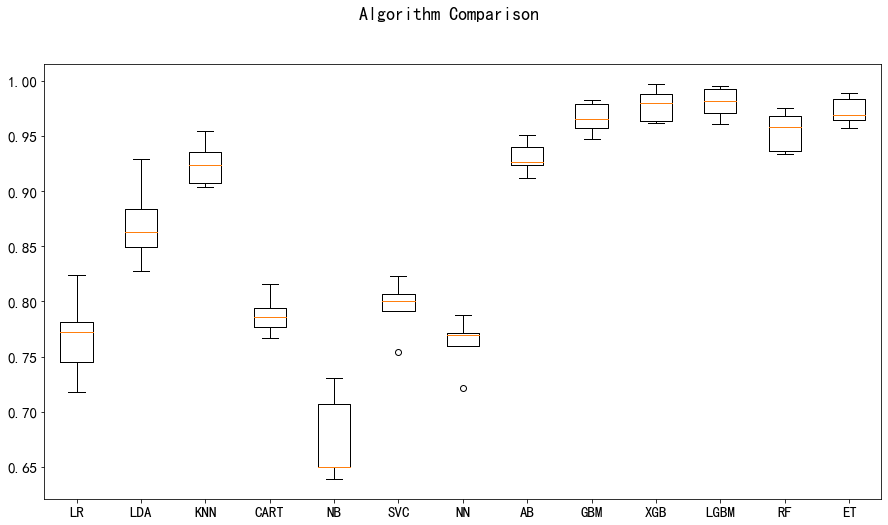

In [99]:
#画图对不同模型进行比较
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [100]:
# 选择合适的评估指标
#scoring = 'accuracy'
#scoring = 'precision'
scoring = 'recall'
#scoring = 'auc'
#scoring = 'roc_auc'

In [101]:
# 对每个模型进行K折交叉验证
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(message)

LR: 0.561873 (0.051976)
LDA: 0.737594 (0.059970)
KNN: 0.862703 (0.037285)
CART: 0.804937 (0.046373)
NB: 0.487240 (0.253207)
SVC: 0.386366 (0.041567)
NN: 0.637672 (0.075984)
AB: 0.843672 (0.043494)
GBM: 0.879970 (0.045067)
XGB: 0.937380 (0.035571)
LGBM: 0.943344 (0.030500)
RF: 0.848671 (0.056310)
ET: 0.903623 (0.043540)


In [102]:
recall_all  = pd.DataFrame(index=names,data = np.mean(results,axis=1),columns=['recall']).T
recall_all

,LR,LDA,KNN,CART,NB,SVC,NN,AB,GBM,XGB,LGBM,RF,ET
recall,0.561873,0.737594,0.862703,0.804937,0.48724,0.386366,0.637672,0.843672,0.87997,0.93738,0.943344,0.848671,0.903623


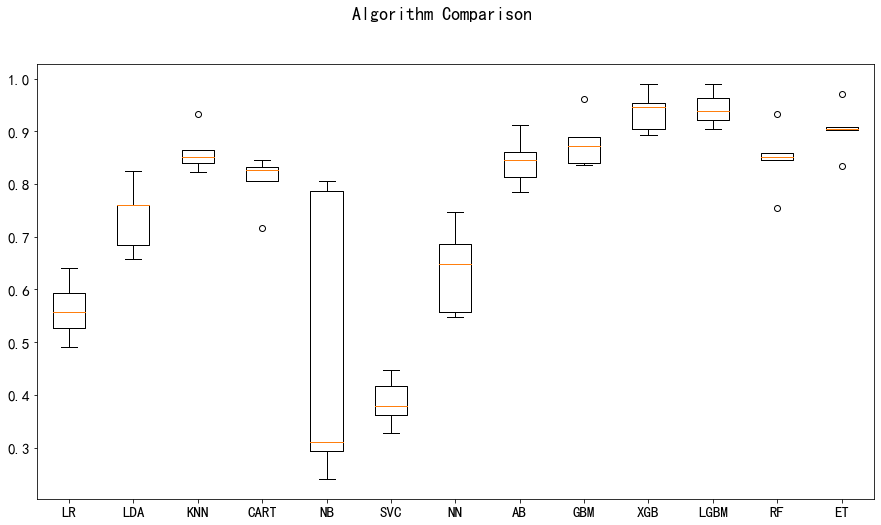

In [103]:
#画图对不同模型进行比较
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [104]:
model_compare = pd.concat([reacall_all,roc_all], axis=0, ignore_index=False)
model_compare

,LR,LDA,KNN,CART,NB,SVC,NN,AB,GBM,XGB,LGBM,RF,ET
recall,0.561873,0.737594,0.862703,0.788236,0.487240,0.386366,0.723781,0.843672,0.883891,0.937380,0.943344,0.856757,0.891871
roc_auc,0.768199,0.870703,0.924931,0.787839,0.675423,0.795406,0.762147,0.930654,0.966170,0.978062,0.980171,0.954364,0.972341


In [106]:
model_compare.to_excel('模型比较.xlsx')

可以看到，AB、GBM、XGB、LGBM、RF、ET模型的表现相对较好,其中LGBM表现最好，选为所用模型

### 6. 特征工程
通过不同方法进行特征选择

In [107]:
len(dataset.columns)

130

In [108]:
dataset.dtypes.value_counts()

float64    127
int32        3
dtype: int64

#### 6.1 根据金融财务知识进行特征选择

In [109]:
index_choose = pd.read_excel('变量选择.xlsx', sheet_name='财务指标', index_col=0)
index_list = list(index_choose.iloc[:, 0])  #.append('isDefault')#.remove('列名')
index_list.append('isDefault')
index_list.remove('s_fa_longdebttoworkingcapital')
del index_list[0]
del index_list[1]
not_drop_list_fin = index_list
not_drop_list_fin

['industryphy',
 'enttype',
 'prov',
 's_fa_current',
 's_fa_quick',
 's_fa_cashratio',
 's_fa_cashtoliqdebt',
 's_fa_debttoassets',
 's_fa_ebittointerest',
 's_fa_tangibleassettonetdebt',
 's_fa_tangassettointdebt',
 's_fa_grossprofitmargin',
 's_fa_profittogr',
 's_fa_roe',
 's_fa_roa2',
 's_fa_invturn',
 's_fa_arturn',
 's_fa_yoy_or',
 's_fa_yoyebt',
 's_fa_yoy_equity',
 's_fa_yoyroe',
 's_fa_ocftoshortdebt',
 's_fa_ocftodebt',
 'isDefault']

#### 6.2 通过算法进行特征选择

##### 6.2.1 根据与预测变量的相关系数进行选择

In [110]:
correlation = dataset.corr()
correlation_isDefault = abs(correlation['isDefault'])
correlation_isDefault.sort_values(ascending=False)

isDefault                     1.000000
s_fa_current                  0.319152
industryphy                   0.301979
s_fa_longdebtodebt            0.289156
s_fa_currentdebttodebt        0.286215
                                ...   
s_fa_arturndays               0.007248
s_fa_cfps                     0.006385
s_fa_nonoperateprofittoebt    0.005522
s_fa_noptoebt                 0.005227
s_fa_optoebt                  0.005208
Name: isDefault, Length: 130, dtype: float64

In [111]:
# 与isDefault相关性低于0.03的特征
drop_list_corr = list(correlation_isDefault[correlation_isDefault<0.03].index)

##### 6.2.2 LassoCV特征选择

In [112]:
X = dataset.drop("isDefault", axis=1)
Y = dataset["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=9)
model_lasso = LassoCV(alphas=[0.1, 1, 0.001, 0.0005], cv=10).fit(X_train, Y_train)
coef = pd.Series(model_lasso.coef_, index=X_train.columns)

In [113]:
# 系数等于0的特征
drop_list_lasso = list(coef[coef==0].index)

##### 6.2.3 XGBoost特征选择

In [114]:
X = dataset.drop("isDefault", axis=1)
Y = dataset["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X,  Y, test_size=0.3, random_state=9)
model = xgb.XGBClassifier()
model.fit(X_train, Y_train)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

In [115]:
# 选择模型特征重要性前40的特征
not_drop_list_xgb = list(feat_importances.nlargest(40).index)
not_drop_list_xgb.append('isDefault')

### 7. 特征选择方案对比

由于LGBM表现较优，用LGBM模型对不同特征组进行比较，进而选择出最优的特征组

#### 7.1 未经特征选择

In [116]:
X = dataset.drop("isDefault", axis=1)
Y = dataset["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=5)
# 训练模型
model = lgb.LGBMClassifier()
model.fit(X_train, Y_train)
# 预测
Y_pred = model.predict(X_test)
# 计算指标
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = metrics.accuracy_score(Y_test, Y_pred)
precis = metrics.precision_score(Y_test, Y_pred)
recall = metrics.recall_score(Y_test, Y_pred)
conf = metrics.confusion_matrix(Y_test, Y_pred)

In [117]:
dataset.shape

(1766, 130)

In [118]:
print("accuracy:", acc)
print("precision:", precis)
print("recall:", recall)
print("auc:", auc)


accuracy: 0.9245283018867925
precision: 0.8938775510204081
recall: 0.9399141630901288
auc: 0.9261860377740205


#### 7.2 金融财务知识特征选择

In [119]:
dataset_fin = dataset[not_drop_list_fin]
X = dataset_fin.drop("isDefault", axis=1)
Y = dataset_fin["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
# 训练模型
model = lgb.LGBMClassifier()
model.fit(X_train, Y_train)
# 预测
Y_pred = model.predict(X_test)
# 计算指标
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = metrics.accuracy_score(Y_test, Y_pred)
precis = metrics.precision_score(Y_test, Y_pred)
recall = metrics.recall_score(Y_test, Y_pred)
conf = metrics.confusion_matrix(Y_test, Y_pred)

In [120]:
dataset_fin.shape

(1766, 24)

In [121]:
print("accuracy:", acc)
print("precision:", precis)
print("recall:", recall)
print("auc:", auc)

accuracy: 0.9452830188679245
precision: 0.9330543933054394
recall: 0.9449152542372882
auc: 0.9452467427649026


#### 7.3 相关系数特征选择

In [122]:
dataset_corr = dataset.drop(labels=drop_list_corr, axis=1)
X = dataset_corr.drop("isDefault", axis=1)
Y = dataset_corr["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
# 训练模型
model = lgb.LGBMClassifier()
model.fit(X_train, Y_train)
# 预测
Y_pred = model.predict(X_test)
# 计算指标
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = metrics.accuracy_score(Y_test, Y_pred)
precis = metrics.precision_score(Y_test, Y_pred)
recall = metrics.recall_score(Y_test, Y_pred)
conf = metrics.confusion_matrix(Y_test, Y_pred)

In [123]:
dataset_corr.shape

(1766, 100)

In [124]:
print("accuracy:", acc)
print("precision:", precis)
print("recall:", recall)
print("auc:", auc)

accuracy: 0.9471698113207547
precision: 0.9262295081967213
recall: 0.9576271186440678
auc: 0.9482013144240747


#### 7.4 Lasso特征选择

In [125]:
dataset_lasso = dataset.drop(labels=drop_list_lasso, axis=1)
X = dataset_lasso.drop("isDefault", axis=1)
Y = dataset_lasso["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
# 训练模型
model = lgb.LGBMClassifier()
model.fit(X_train, Y_train)
# 预测
Y_pred = model.predict(X_test)
# 计算指标
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = metrics.accuracy_score(Y_test, Y_pred)
precis = metrics.precision_score(Y_test, Y_pred)
recall = metrics.recall_score(Y_test, Y_pred)
conf = metrics.confusion_matrix(Y_test, Y_pred)

In [126]:
dataset_lasso.shape

(1766, 127)

In [127]:
print("accuracy:", acc)
print("precision:", precis)
print("recall:", recall)
print("auc:", auc)

accuracy: 0.9490566037735849
precision: 0.9300411522633745
recall: 0.9576271186440678
auc: 0.9499019946961836


#### 7.5 相关系数+Lasso特征选择

In [128]:
drop_list_lc = list(set(drop_list_corr).union(set(drop_list_lasso)))
dataset_lasso_corr=dataset.drop(labels=drop_list_lc, axis=1)
X = dataset_lasso_corr.drop("isDefault", axis=1)
Y = dataset_lasso_corr["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
# 训练模型
model = lgb.LGBMClassifier()
model.fit(X_train, Y_train)
# 预测
Y_pred = model.predict(X_test)
# 计算指标
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = metrics.accuracy_score(Y_test, Y_pred)
precis = metrics.precision_score(Y_test, Y_pred)
recall = metrics.recall_score(Y_test, Y_pred)
conf = metrics.confusion_matrix(Y_test, Y_pred)

In [129]:
dataset_lasso_corr.shape

(1766, 98)

In [130]:
print("accuracy:", acc)
print("precision:", precis)
print("recall:", recall)
print("auc:", auc)

accuracy: 0.9641509433962264
precision: 0.950207468879668
recall: 0.9703389830508474
auc: 0.9647613282601174


#### 7.6 XGBoost特征选择

In [131]:
dataset_xgb = dataset[not_drop_list_xgb]
X = dataset_xgb.drop("isDefault", axis=1)
Y = dataset_xgb["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X,  Y, test_size=0.3, random_state=seed)
# 训练模型
model = lgb.LGBMClassifier()
model.fit(X_train, Y_train)
# 预测
Y_pred = model.predict(X_test)
# 计算指标
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = metrics.accuracy_score(Y_test, Y_pred)
precis = metrics.precision_score(Y_test, Y_pred)
recall = metrics.recall_score(Y_test, Y_pred)
conf = metrics.confusion_matrix(Y_test, Y_pred)

In [132]:
dataset_xgb.shape

(1766, 41)

In [133]:
print("accuracy:", acc)
print("precision:", precis)
print("recall:", recall)
print("auc:", auc)

accuracy: 0.9622641509433962
precision: 0.9462809917355371
recall: 0.9703389830508474
auc: 0.9630606479880087



### 8. 最终模型调整

#### 8.1 特征选择
采用相关性+Lasso获得的特征最优

In [134]:
dataset=dataset_lasso_corr
dataset.shape

(1766, 98)

In [135]:
list(dataset.columns)

['s_fa_operateincome',
 's_fa_ebit',
 's_fa_fcfe',
 's_fa_tangibleasset',
 's_fa_workingcapital',
 's_fa_networkingcapital',
 's_fa_retainedearnings',
 's_fa_eps_diluted2',
 's_fa_bps',
 's_fa_surpluscapitalps',
 's_fa_ebitps',
 's_fa_fcffps',
 's_fa_fcfeps',
 's_fa_netprofitmargin',
 's_fa_grossprofitmargin',
 's_fa_expensetosales',
 's_fa_profittogr',
 's_fa_saleexpensetogr',
 's_fa_adminexpensetogr',
 's_fa_finaexpensetogr',
 's_fa_impairtogr_ttm',
 's_fa_gctogr',
 's_fa_optogr',
 's_fa_ebittogr',
 's_fa_roe',
 's_fa_roa2',
 's_fa_roa',
 's_fa_roic',
 's_fa_roe_yearly',
 's_fa_roa2_yearly',
 's_fa_investincometoebt',
 's_fa_taxtoebt',
 's_fa_salescashintoor',
 's_fa_ocftoor',
 's_fa_debttoassets',
 's_fa_assetstoequity',
 's_fa_dupont_assetstoequity',
 's_fa_catoassets',
 's_fa_ncatoassets',
 's_fa_tangibleassetstoassets',
 's_fa_intdebttototalcap',
 's_fa_equitytototalcapital',
 's_fa_currentdebttodebt',
 's_fa_longdebtodebt',
 's_fa_current',
 's_fa_quick',
 's_fa_cashratio',
 's_

#### 8.2 参数选择
LGBM模型表现最优，进一步对LGBM模型采用网格搜索获取最优参数

In [136]:
X = dataset.drop("isDefault", axis=1)
Y = dataset["isDefault"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [137]:
model = lgb.LGBMClassifier()
param_dist = {
    "max_depth": [25, 50, 75],
    "learning_rate": [0.01, 0.1, 0.15],
    "num_leaves": [100, 300, 500],
    "n_estimators": [200]
}
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_dist, cv=kfold, scoring=scoring, verbose=10, n_jobs=-1)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best: 0.945425 using {'learning_rate': 0.15, 'max_depth': 25, 'n_estimators': 200, 'num_leaves': 100}


得到最优参数: {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 200, 'num_leaves': 100}

##### 8.3 训练最终模型

In [138]:
# 训练模型
model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=25, n_estimators=200, num_leaves=100)
model.fit(X_train, Y_train)
# 预测
Y_pred = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = metrics.accuracy_score(Y_test, Y_pred)
precis = metrics.precision_score(Y_test, Y_pred)
recall = metrics.recall_score(Y_test, Y_pred)
conf = metrics.confusion_matrix(Y_test, Y_pred)

In [139]:
print("accuracy:",acc)
print("precision:",precis)
print("recall:",recall)
print("auc:",auc)

accuracy: 0.9641509433962264
precision: 0.9465020576131687
recall: 0.9745762711864406
auc: 0.9651792920558054


In [140]:
print(conf)

[[281  13]
 [  6 230]]


In [141]:
print(metrics.classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       294
         1.0       0.95      0.97      0.96       236

    accuracy                           0.96       530
   macro avg       0.96      0.97      0.96       530
weighted avg       0.96      0.96      0.96       530



##### 8.4 最终模型中的特征重要性

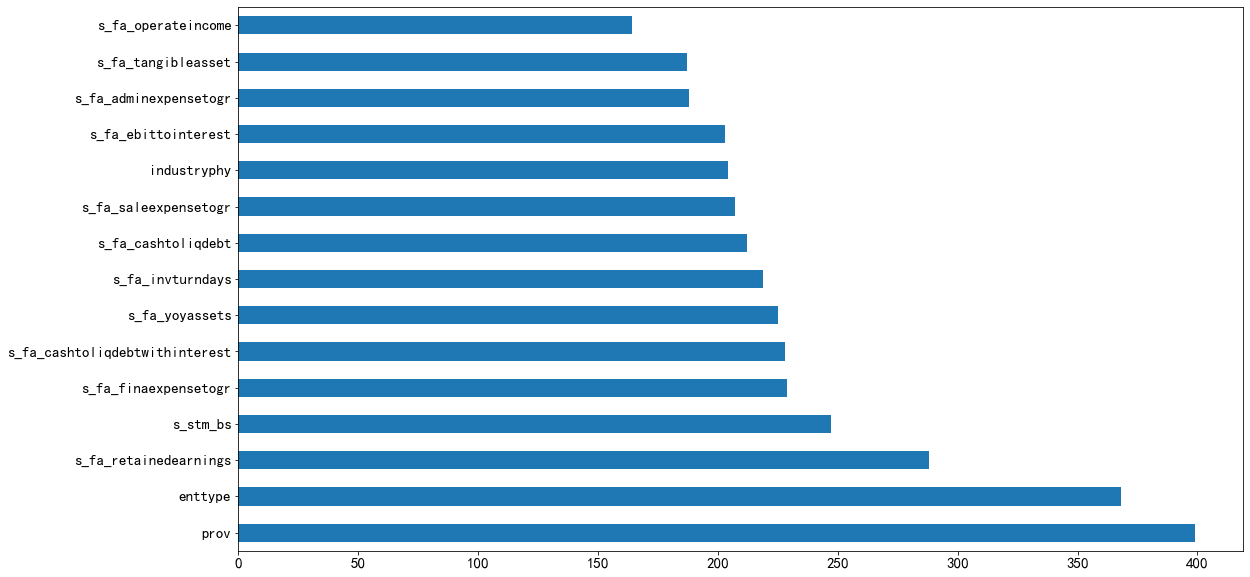

In [142]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(18, 10))
feat_importances.nlargest(15).plot(kind='barh')
plt.show()